In [41]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [42]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10
random_seed = 1
cuda = torch.device('cuda')
torch.manual_seed(random_seed)

In [43]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data_row/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data_row/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])),
    batch_size=batch_size_test, shuffle=True)

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [45]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=0)

In [46]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [47]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.cuda()
        target=target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

In [48]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.cuda()
            target=target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [49]:
import matplotlib.pyplot as plt

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\32571\AppData\Local\Temp\ipykernel_8548\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300651
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.321117
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.319974
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299370
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.291290
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.312634
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.301124
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.314018
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.299428
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.304534
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.291025
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.293091
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.283573
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.285419
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.290574
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.302167
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.274162
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.290471
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.279954
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.287191
Train Epoch: 1 [12800/60000 (

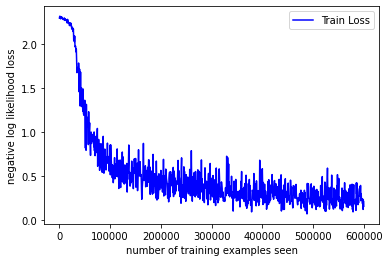

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

$$